In [4]:
import os, gc, re, time, pickle
from abc import ABCMeta, abstractmethod
from pathlib import Path
from contextlib import contextmanager
import pandas as pd
import numpy as np
import category_encoders as ce
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [5]:
os.listdir('../data/input')

['.DS_Store',
 'calendar.csv',
 'sell_prices.csv',
 'data.pkl',
 'sales_train_validation.csv',
 'sample_submission.csv']

In [6]:
with open('../data/input/data.pkl', 'rb') as f:
    df = pickle.load(f)

In [7]:
df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,demand,part,date,wm_yr_wk,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,train,2011-01-29,11101,NaN,NaN,NaN,NaN,0,0,0,NaN
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,train,2011-01-29,11101,NaN,NaN,NaN,NaN,0,0,0,NaN
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,train,2011-01-29,11101,NaN,NaN,NaN,NaN,0,0,0,NaN
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,train,2011-01-29,11101,NaN,NaN,NaN,NaN,0,0,0,NaN
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,train,2011-01-29,11101,NaN,NaN,NaN,NaN,0,0,0,NaN


In [11]:
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['weekday'] = df['date'].dt.weekday

In [60]:
df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,demand,part,date,wm_yr_wk,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,year,month,weekday,event_name_1_l,event_type_1_l,event_name_2_l,event_type_2_l
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,train,2011-01-29,11101,Nodata,Nodata,Nodata,Nodata,0,0,0,NaN,2011,1,5,0,0,0,0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,train,2011-01-29,11101,Nodata,Nodata,Nodata,Nodata,0,0,0,NaN,2011,1,5,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,train,2011-01-29,11101,Nodata,Nodata,Nodata,Nodata,0,0,0,NaN,2011,1,5,0,0,0,0
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,train,2011-01-29,11101,Nodata,Nodata,Nodata,Nodata,0,0,0,NaN,2011,1,5,0,0,0,0
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,train,2011-01-29,11101,Nodata,Nodata,Nodata,Nodata,0,0,0,NaN,2011,1,5,0,0,0,0


In [59]:
# Label
event_col = ['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
for c in event_col:
    df[c] = df[c].fillna('Nodata')
    df[c + '_l'] = df[c].apply(lambda x: 0 if x == 'Nodata' else -1)

In [13]:
train = df[df['part'] == 'train']
val = df[df['part'] == 'test1']
eval = df[df['part'] == 'test2']

---
## Date

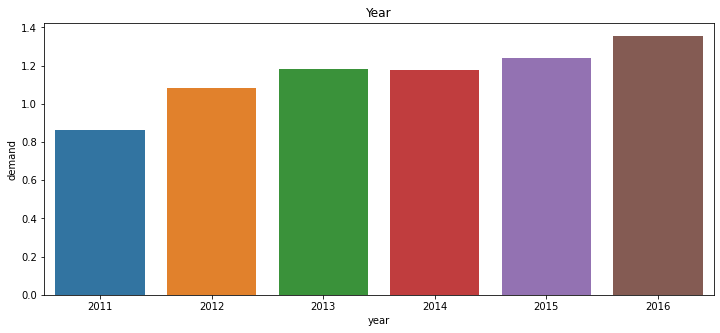

In [19]:
group = train.groupby(['year'])['demand'].mean().reset_index()
fig = plt.figure(figsize=(12, 5), facecolor='w')
sns.barplot(x='year', y='demand', data=group)
plt.title('Year')
plt.show()

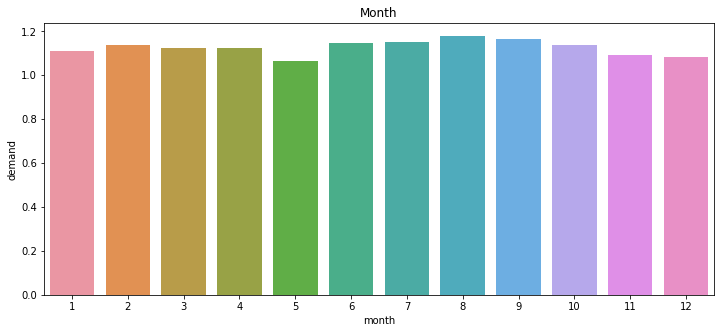

In [20]:
group = train.groupby(['month'])['demand'].mean().reset_index()
fig = plt.figure(figsize=(12, 5), facecolor='w')
sns.barplot(x='month', y='demand', data=group)
plt.title('Month')
plt.show()

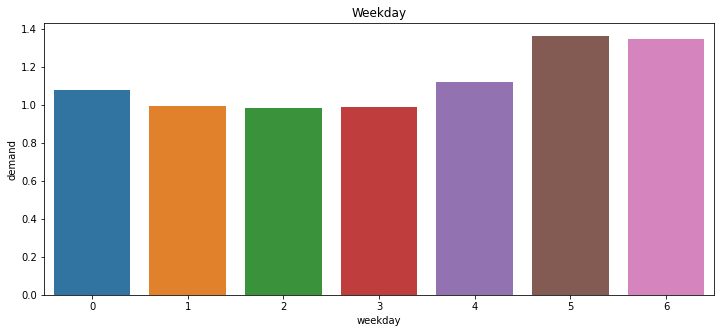

In [21]:
group = train.groupby(['weekday'])['demand'].mean().reset_index()
fig = plt.figure(figsize=(12, 5), facecolor='w')
sns.barplot(x='weekday', y='demand', data=group)
plt.title('Weekday')
plt.show()

---
## Plot

In [45]:
def plot(df, id):
    temp = df[df['id'] == id]
    temp.sort_values(by='date', ascending=True, inplace=True)
    
    fig, ax1 = plt.subplots(figsize=(14, 3), facecolor='w')
    ax2 = ax1.twinx()
    ax1.plot(temp['date'], temp['demand'], color='b', label='demand')
    ax1.plot(temp['date'], temp['sell_price'], color='r', label='sell_price')
    # 凡例
    # グラフの本体設定時に、ラベルを手動で設定する必要があるのは、barplotのみ。plotは自動で設定される＞
    handler1, label1 = ax1.get_legend_handles_labels()
    handler2, label2 = ax2.get_legend_handles_labels()
    # 凡例をまとめて出力する
    ax1.legend(handler1 + handler2, label1 + label2, loc=2, borderaxespad=0.)
    plt.title(id)
    plt.show()

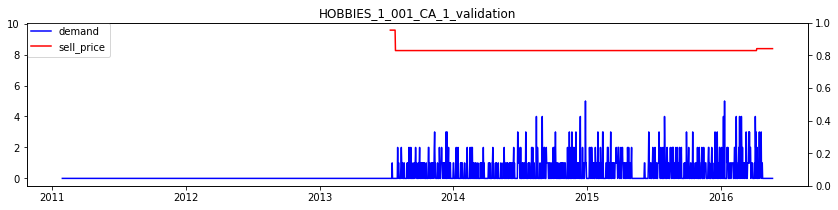

In [61]:
ids = train['id'].unique()
plot(df, ids[0])

In [44]:
len(ids)

30490

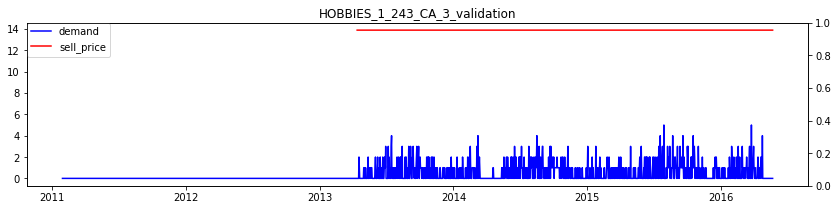

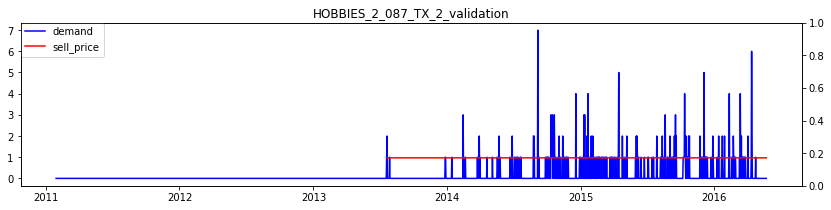

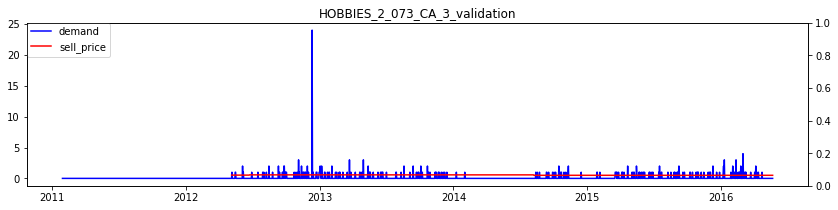

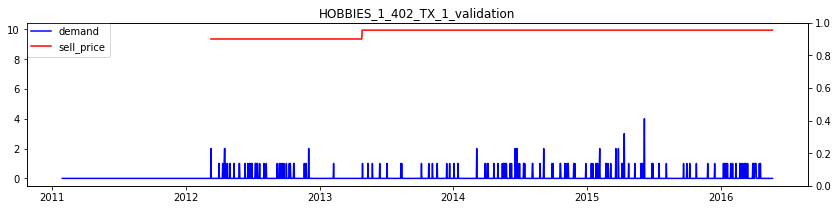

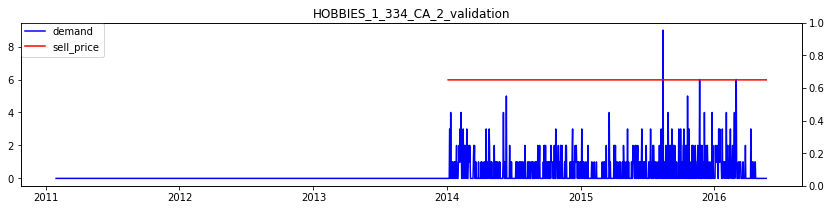

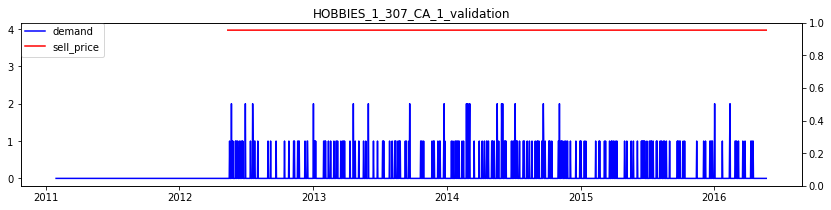

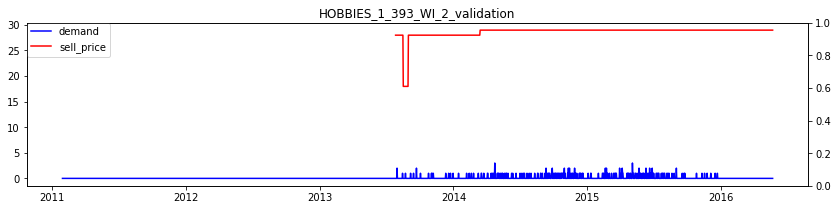

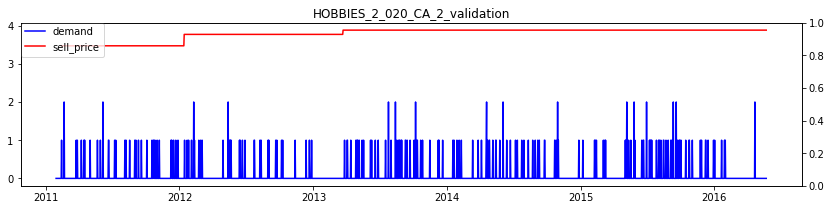

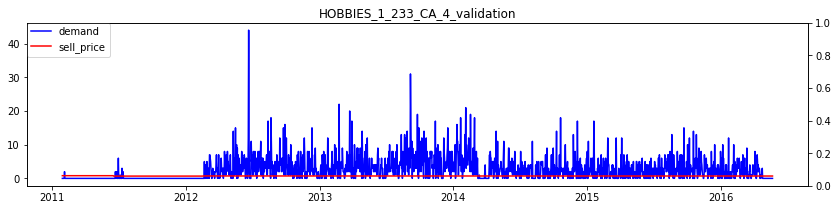

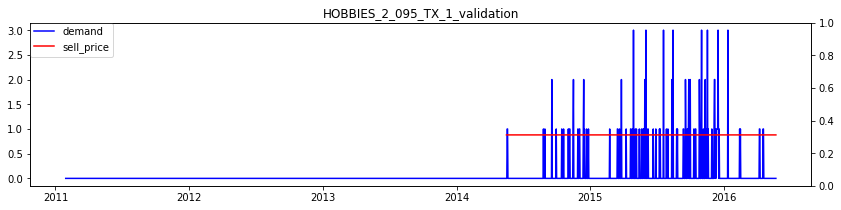

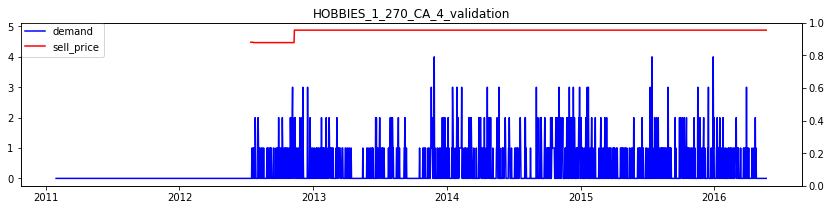

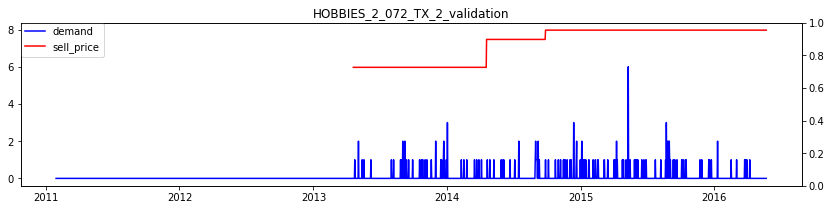

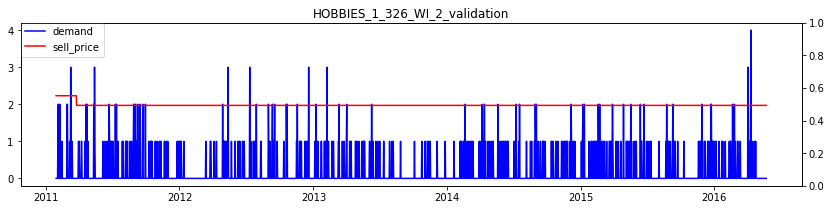

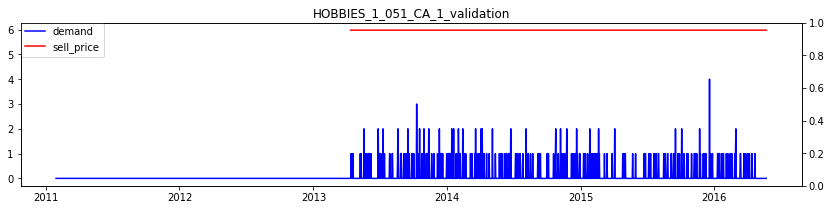

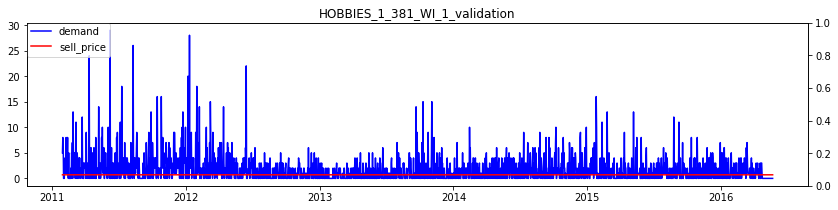

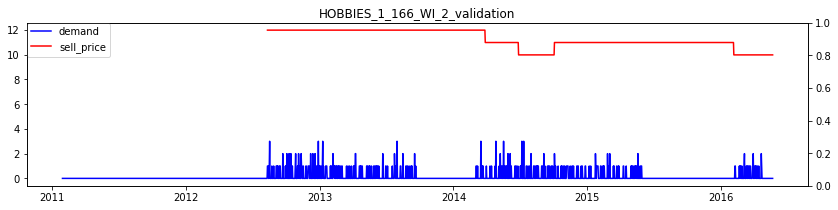

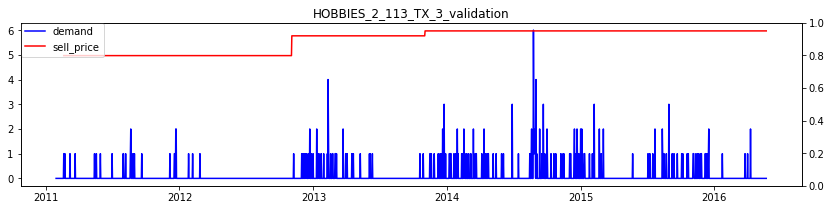

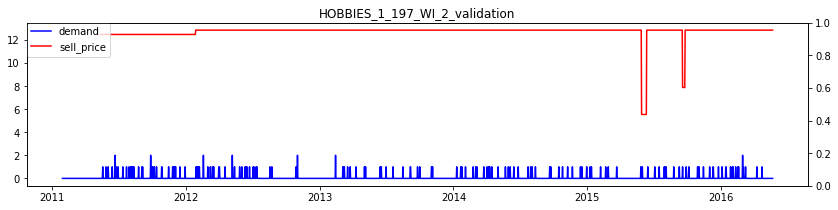

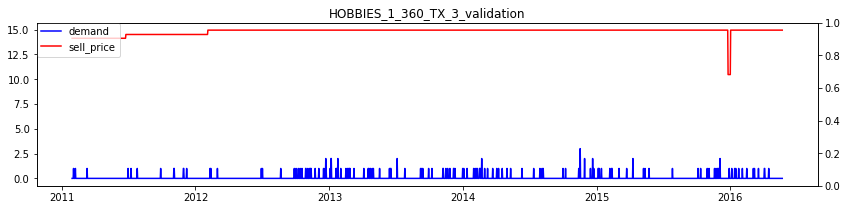

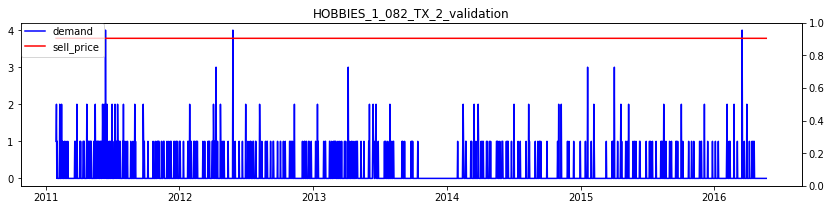

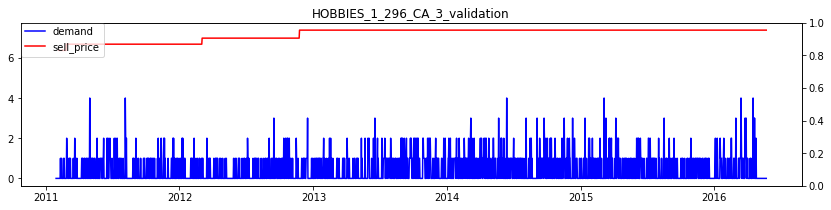

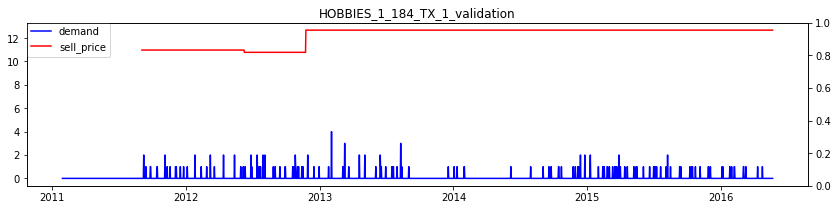

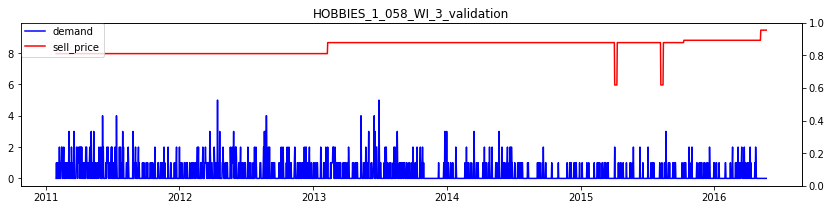

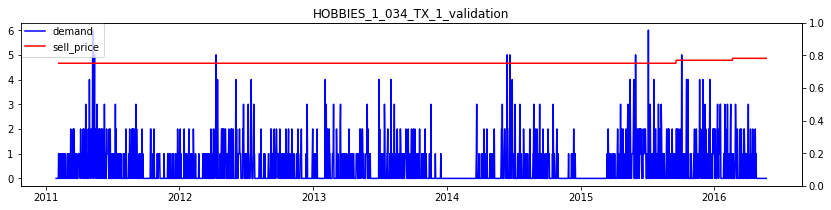

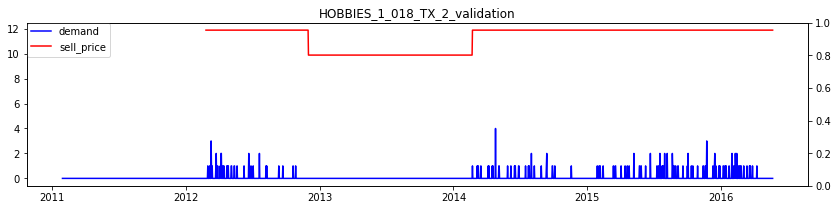

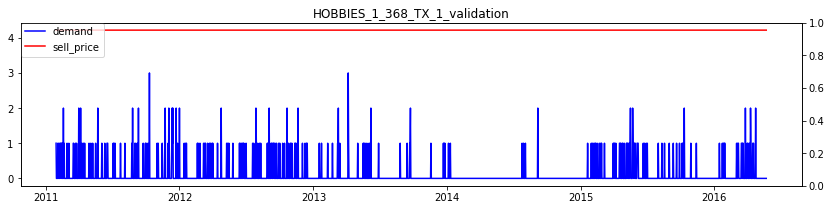

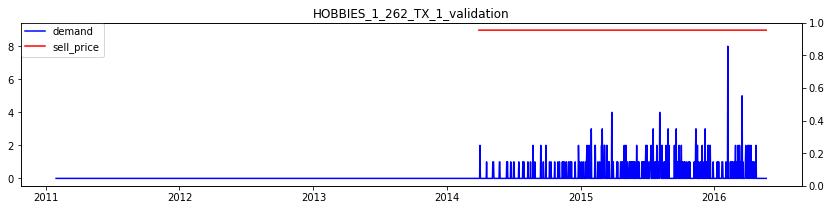

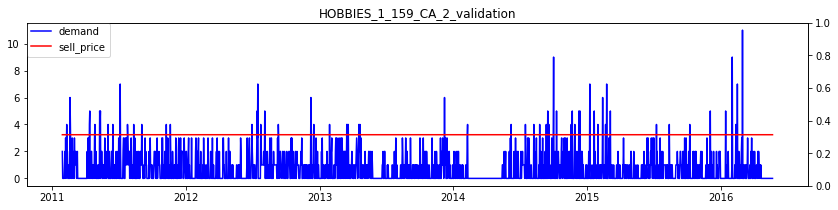

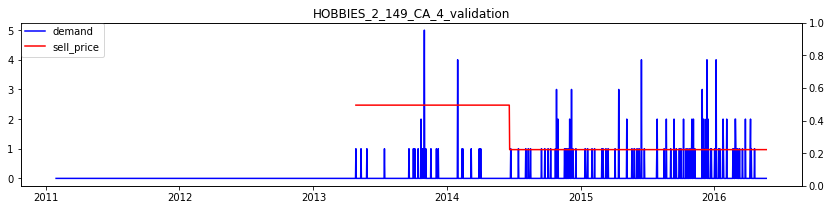

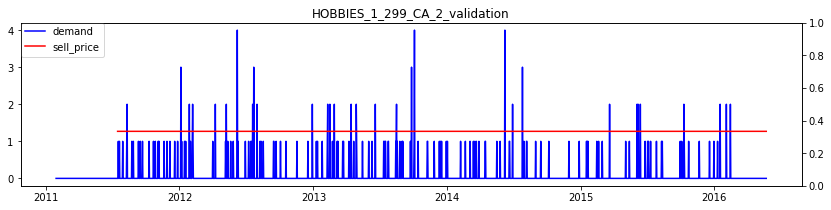

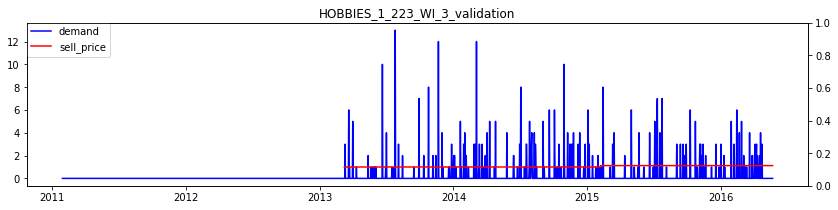

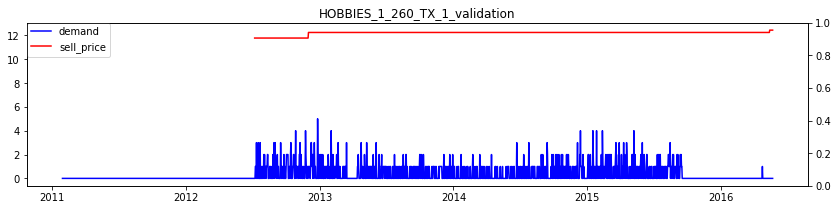

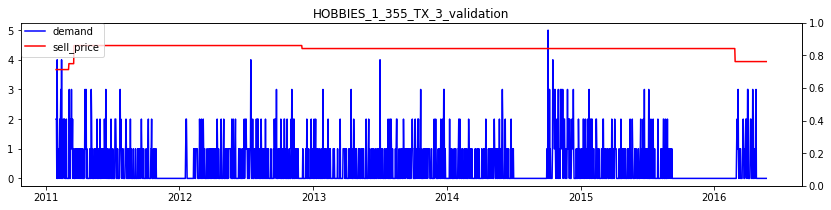

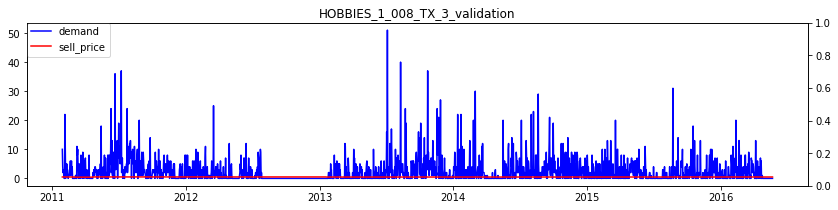

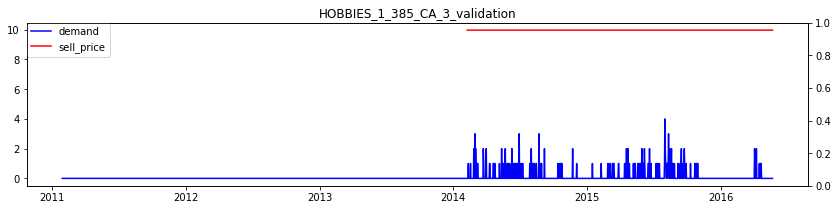

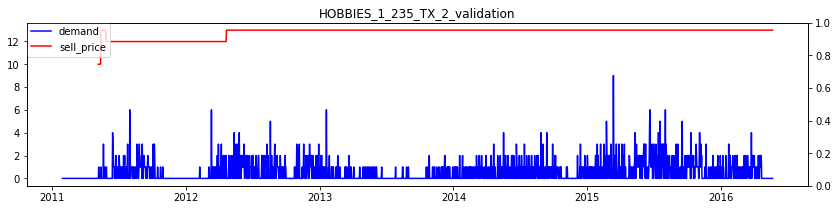

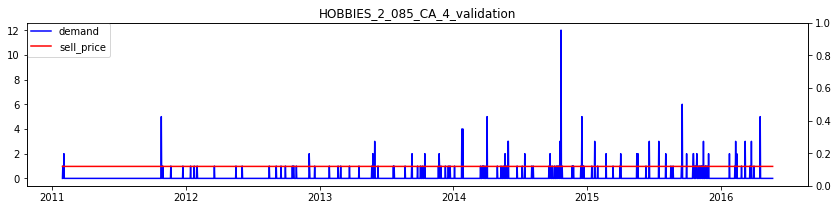

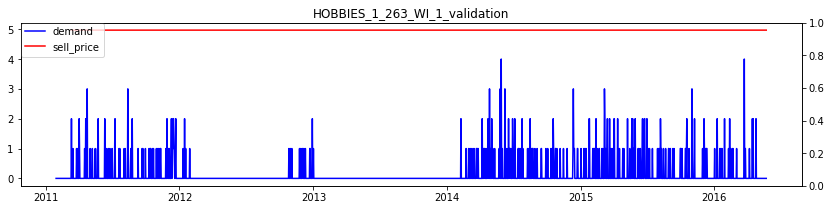

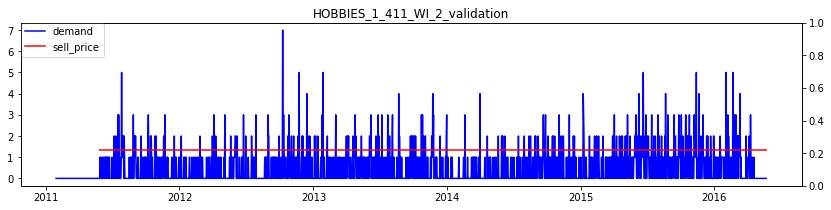

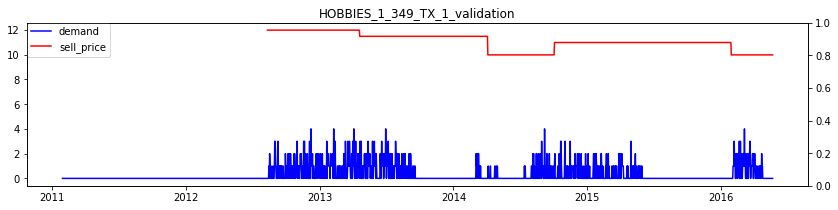

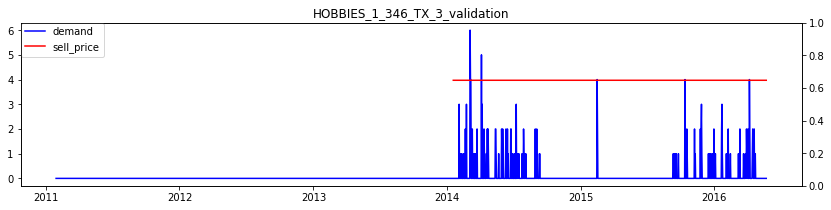

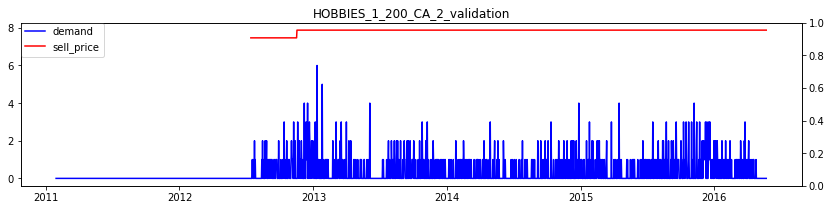

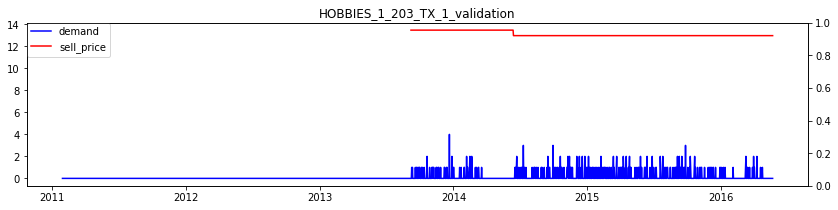

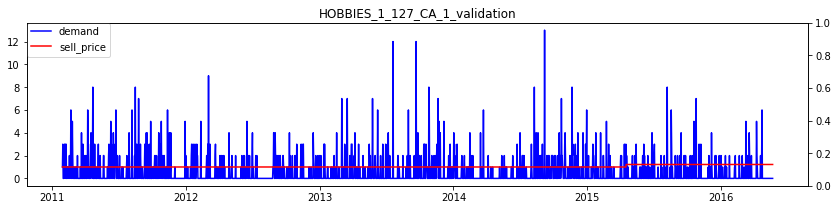

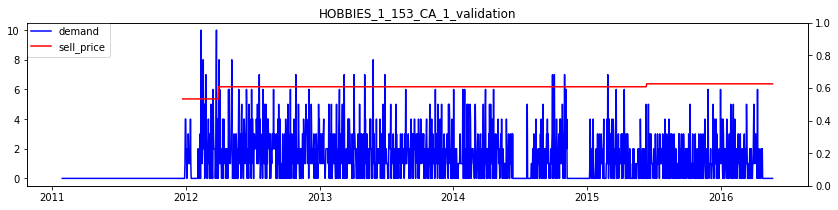

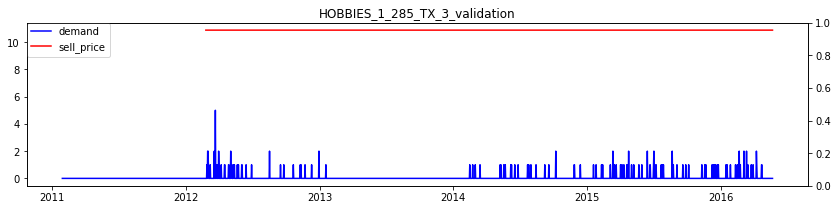

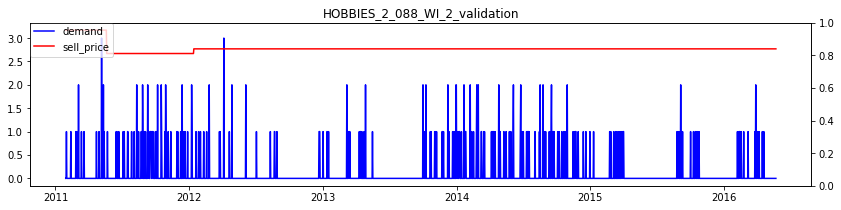

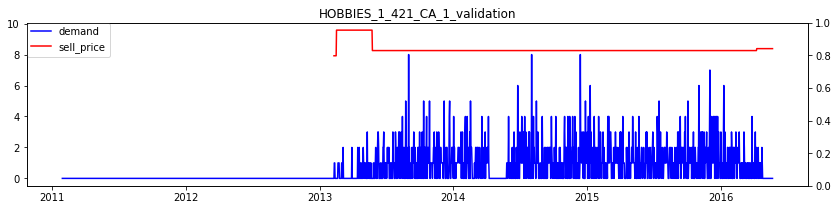

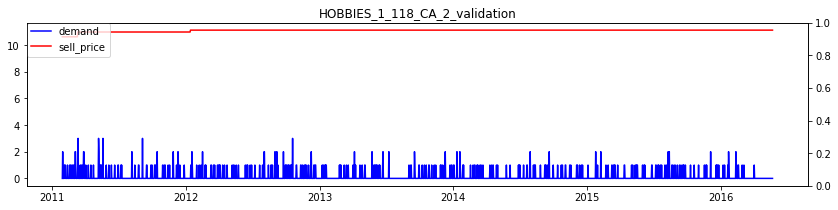

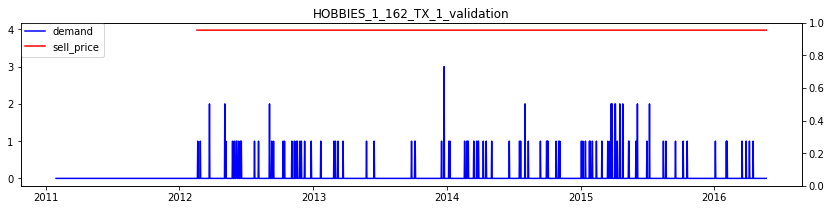

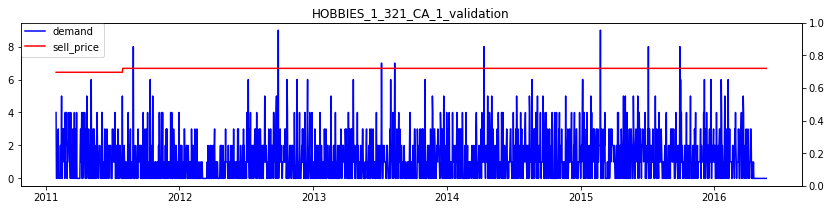

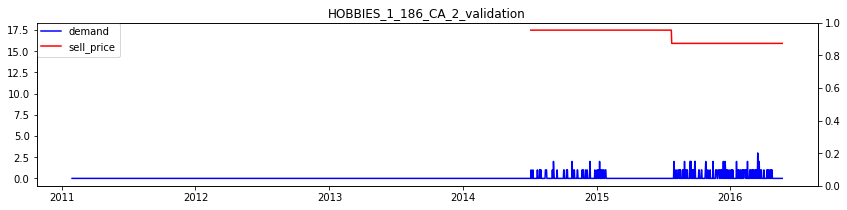

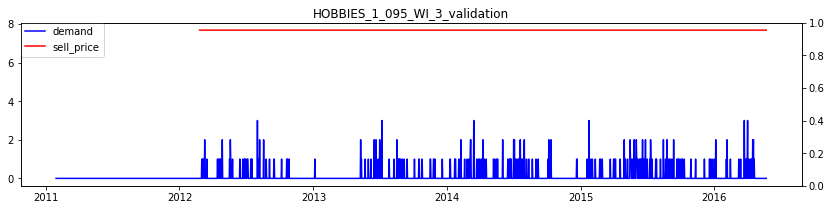

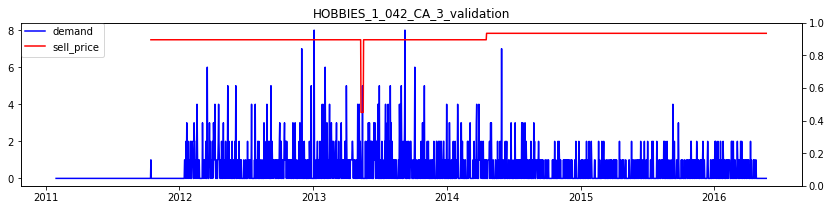

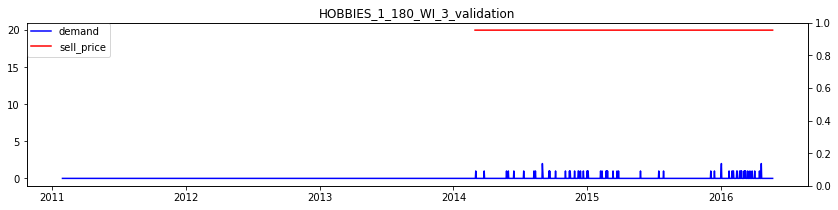

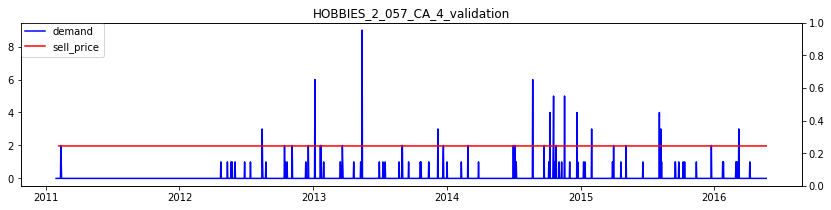

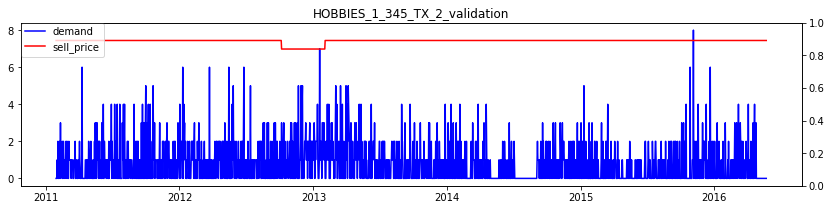

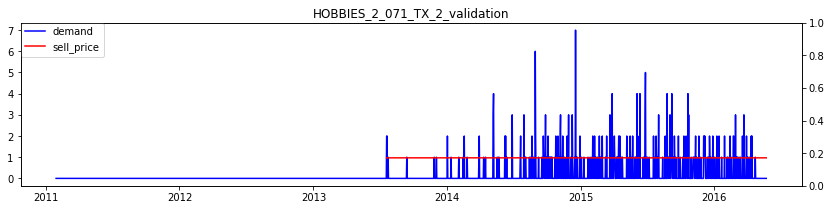

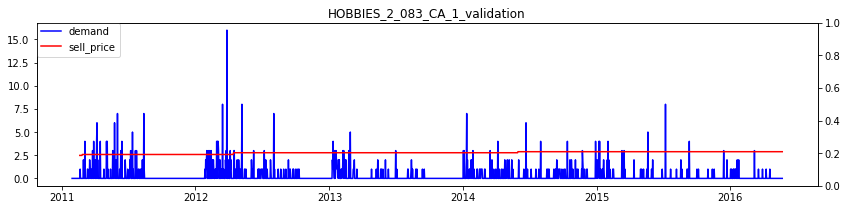

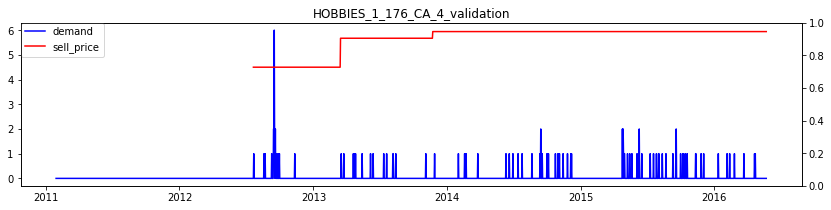

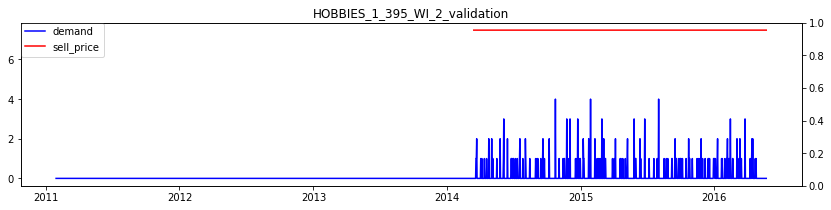

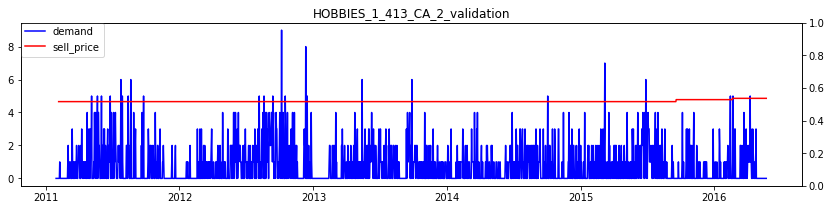

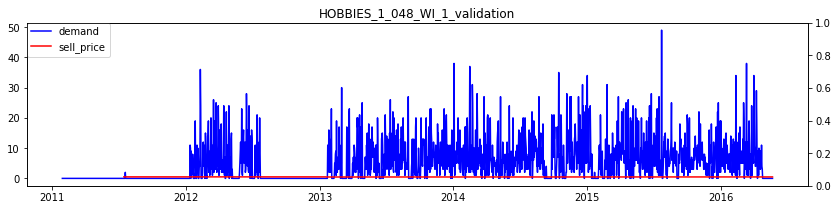

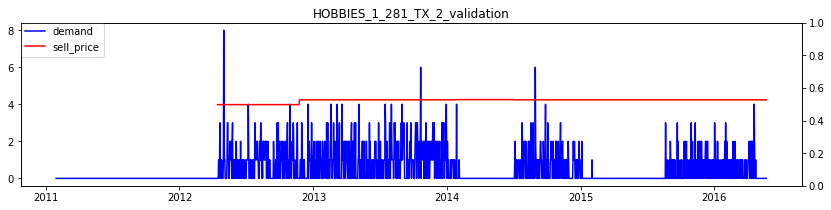

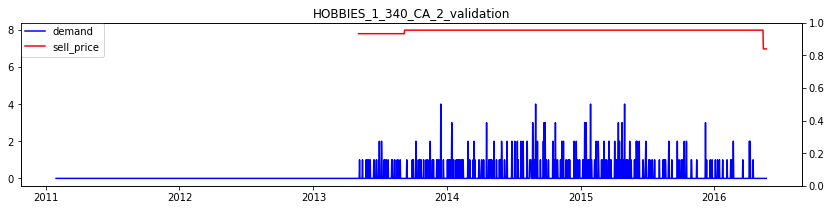

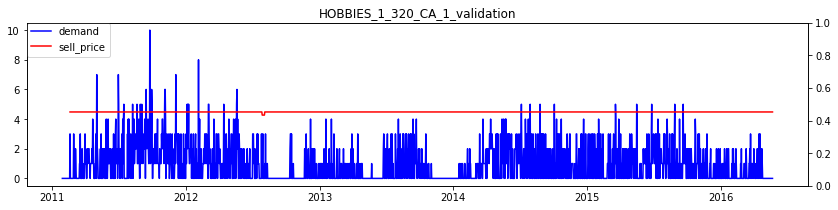

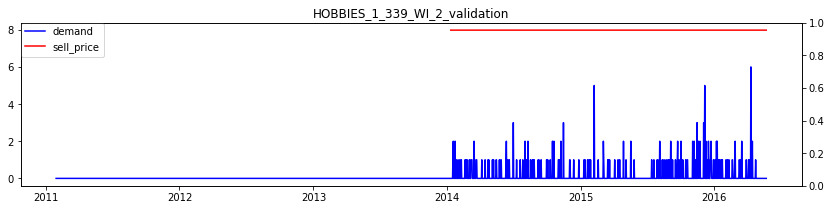

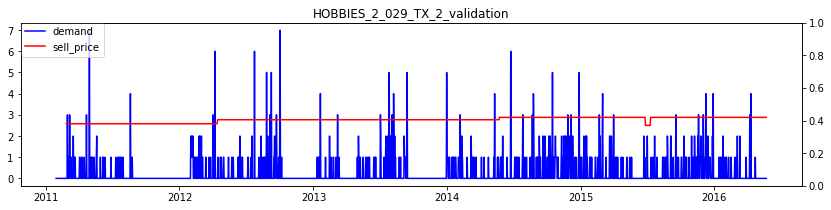

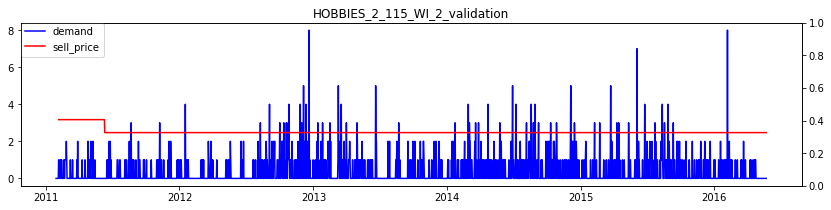

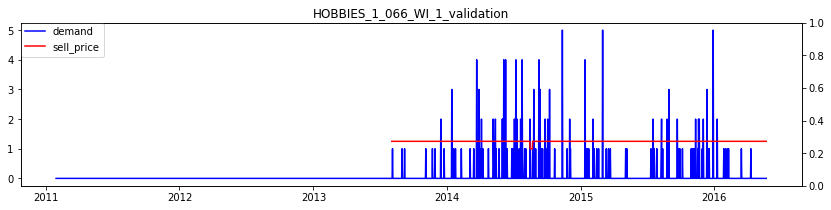

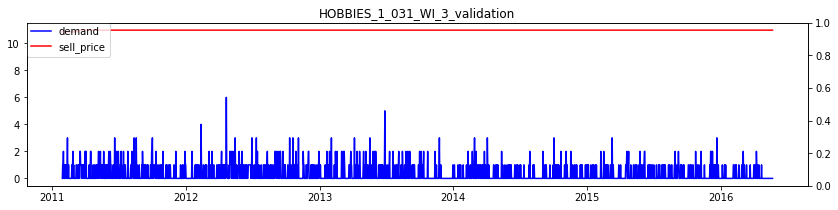

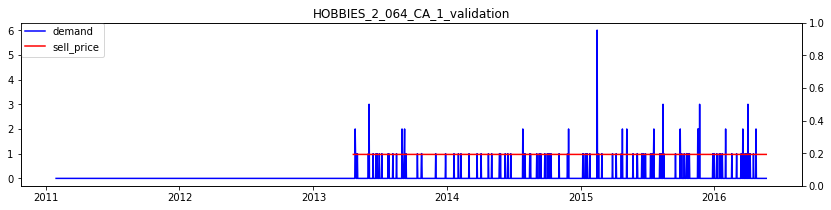

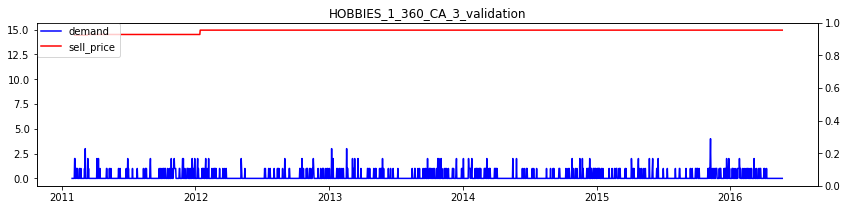

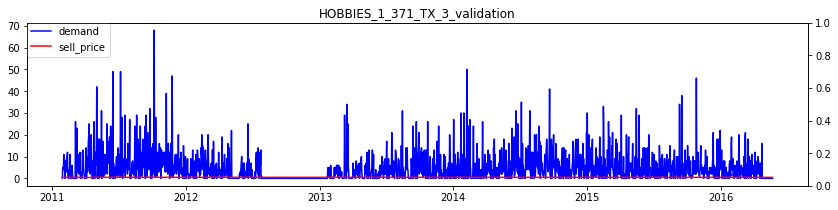

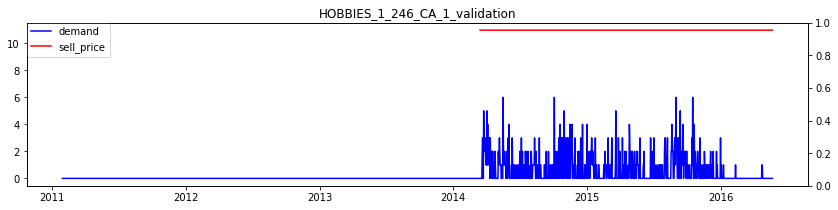

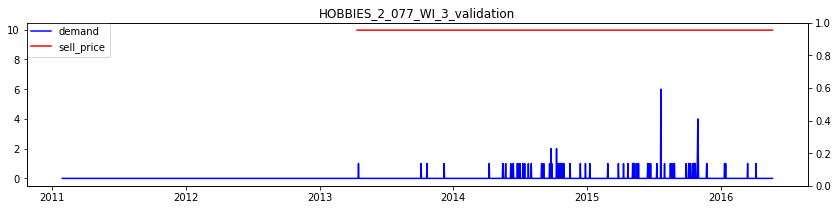

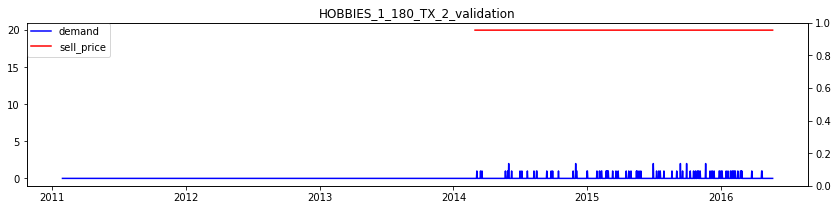

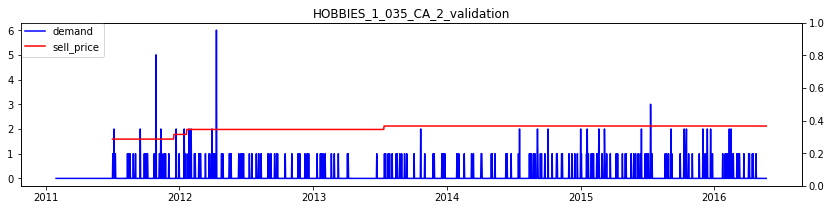

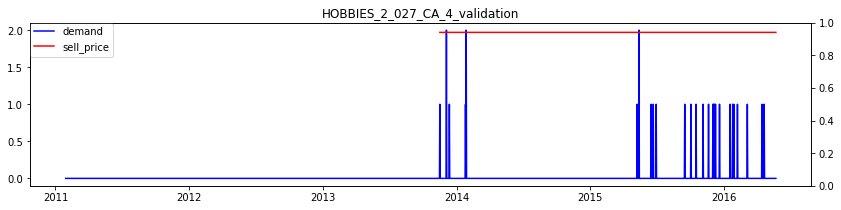

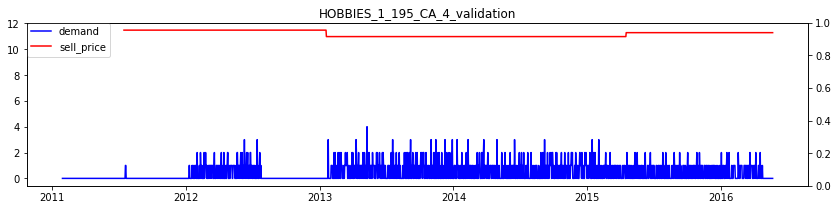

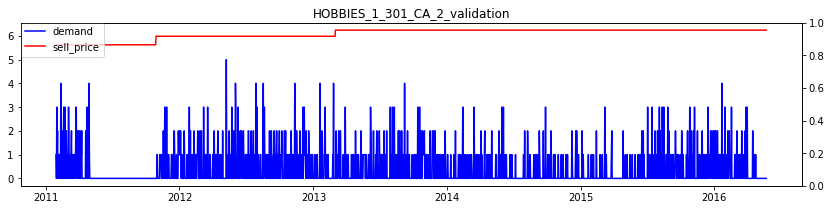

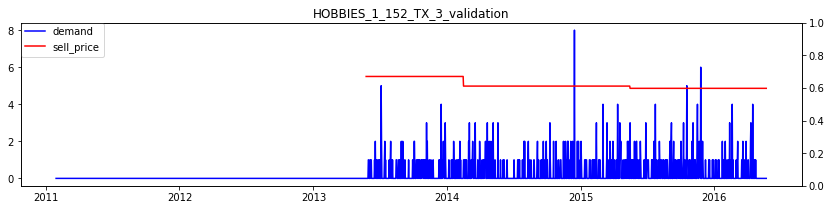

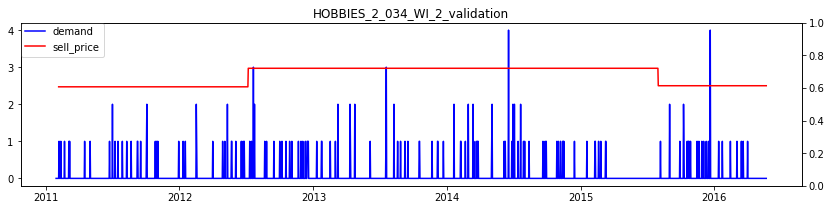

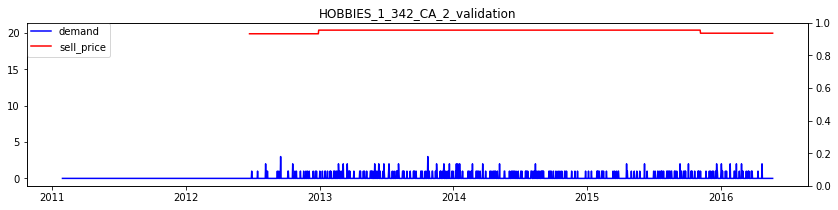

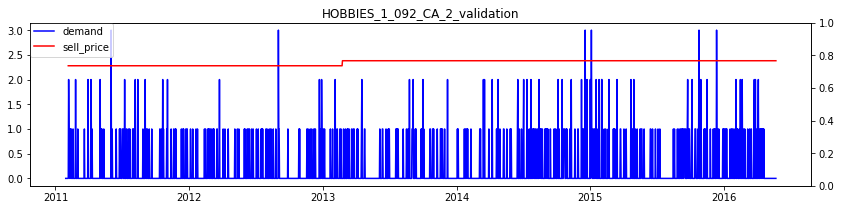

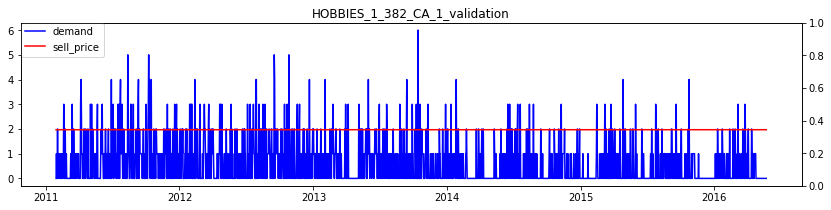

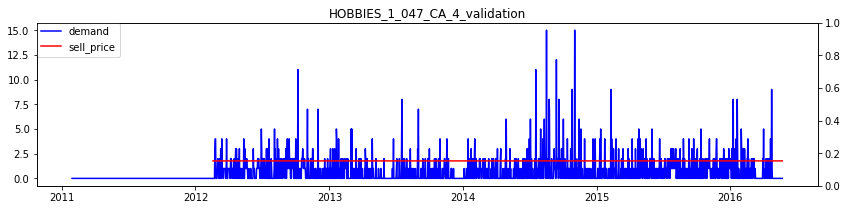

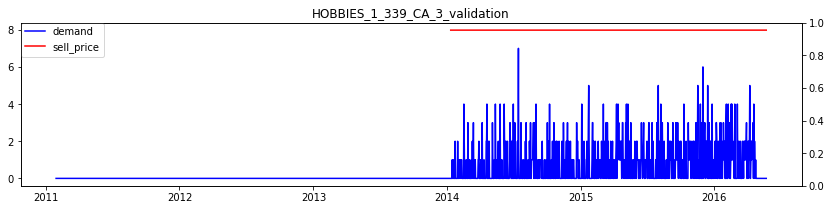

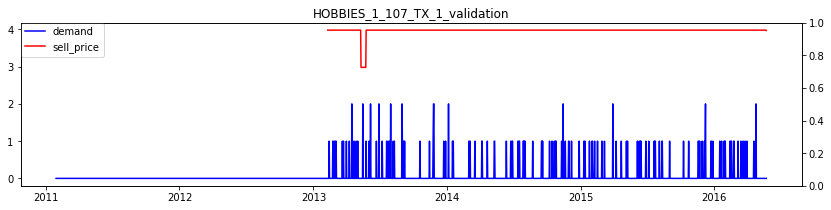

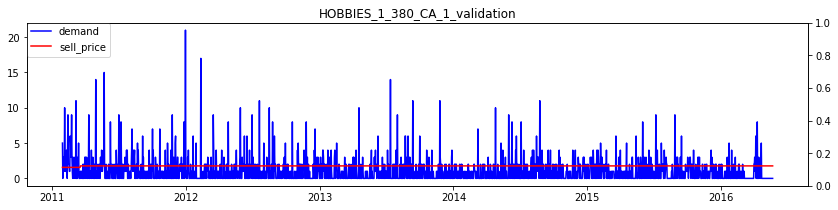

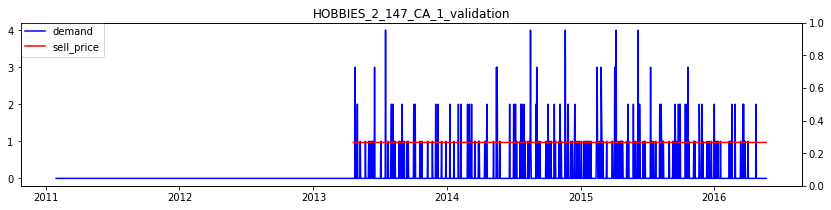

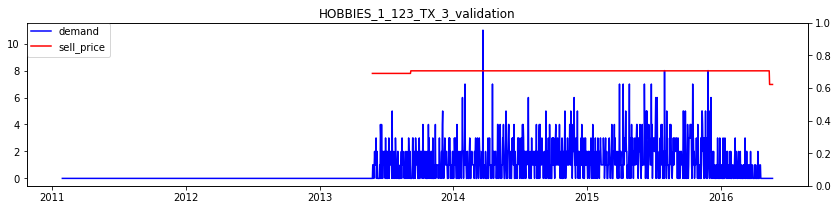

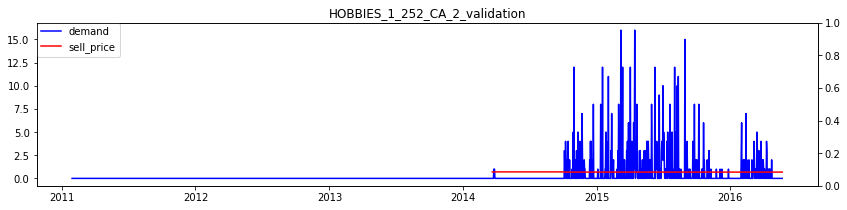

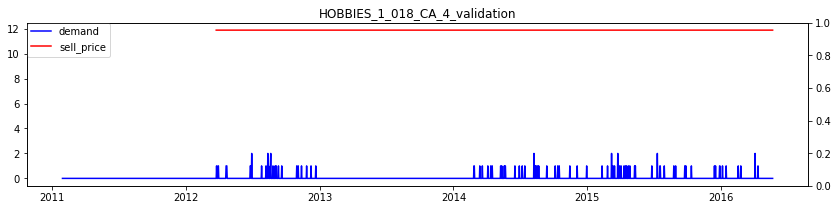

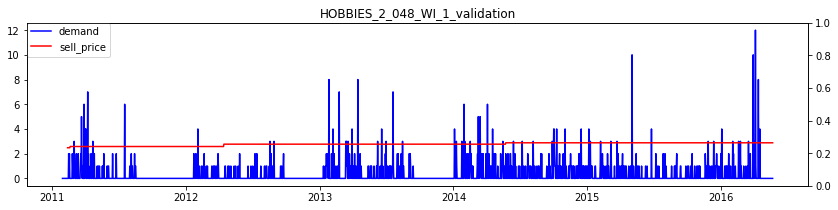

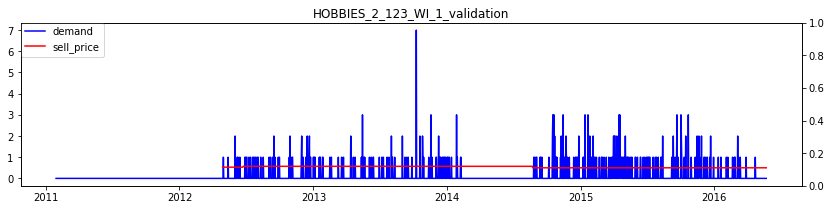

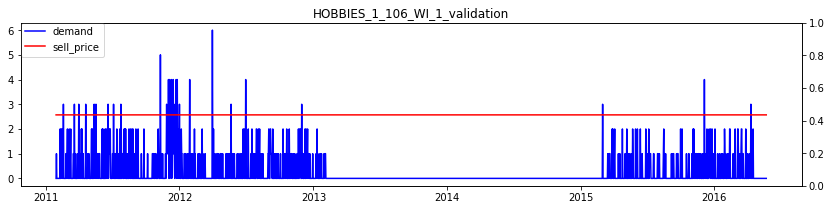

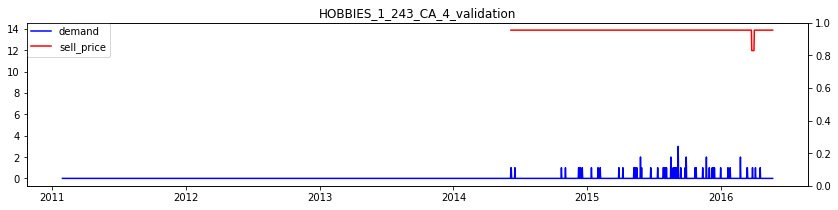

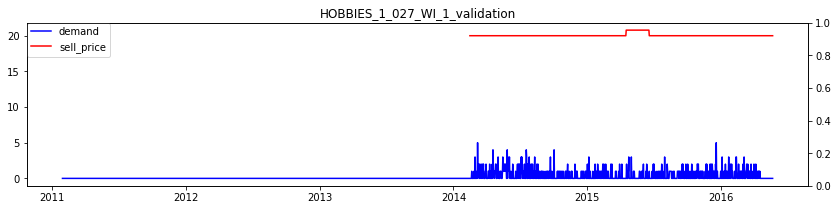

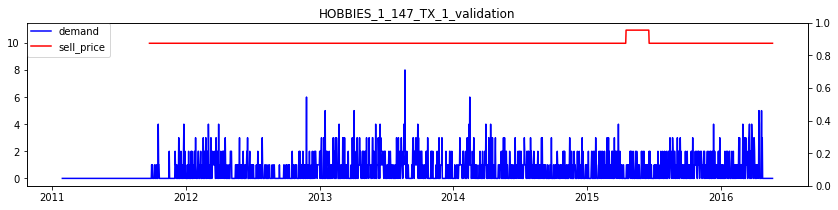

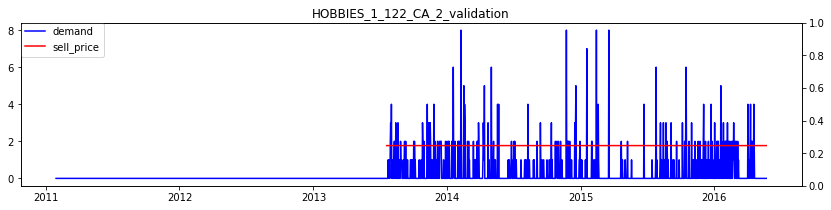

In [56]:
hobbie_id = [id for id in ids if 'HOBBIES' in id]
for i in range(len(hobbie_id)):
    r = np.random.randint(1, len(hobbie_id))
    plot(df, hobbie_id[r])
    if i == 100:
        break

In [51]:
df['cat_id'].unique()

array(['HOBBIES', 'HOUSEHOLD', 'FOODS'], dtype=object)

In [64]:
temp = df[df['id'] == 'HOBBIES_2_071_TX_2_validation']
print(temp['demand'].unique())
print(temp['sell_price'].unique())

[0 2 1 3 4 6 7 5]
[ nan 0.97]


---
### Correlation per dept_id

In [65]:
df['dept_id'].unique()

array(['HOBBIES_1', 'HOBBIES_2', 'HOUSEHOLD_1', 'HOUSEHOLD_2', 'FOODS_1',
       'FOODS_2', 'FOODS_3'], dtype=object)